In [17]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from riskyneuroarousal.utils.load_data import (load_behavioral_data, load_pupil_data, load_pt_results)
from scipy.stats import false_discovery_control
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
behavior = load_behavioral_data(min_RT = 0.2)
pupil_data = load_pupil_data()
data = pupil_data.merge(behavior, on=["sub", "trial"])
data["pupil_size"] = data["ps_preprocessed"] - data["baseline"]
data["loss_over_gain"] = np.log(data["loss"] / data["gain"])

In [5]:
all_subs_effort = []
for sub in behavior["sub"].unique():
    sub_data = behavior.query("sub == @sub")
    response_count = {"accept" : 0, "reject" : 0}
    sub_effort = {"trial" : [], "effort" : [], "sub" : []}
    for trial in sorted(sub_data["trial"].unique()):
        sub_effort["trial"].append(trial)
        sub_effort["sub"].append(sub)

        trial_data = sub_data.query("trial == @trial")
        if trial_data["accept"].values[0] == 1:
            response_count["accept"] += 1
            # I just accepted. If I have been accepting a lot more than rejecting, this is not effortful. 
            if response_count["accept"] > response_count["reject"]:
                sub_effort["effort"].append(0)
            else:
                sub_effort["effort"].append(1)
        else:
            response_count["reject"] += 1
            if response_count["reject"] > response_count["accept"]:
                sub_effort["effort"].append(0)
            else:
                sub_effort["effort"].append(1)
    all_subs_effort.append(pd.DataFrame(sub_effort))
effort = pd.concat(all_subs_effort)

In [7]:
data = data.merge(effort, on=["sub", "trial"])
data["effort"] = data["effort"].astype("category")
data["effort"] = data["effort"].cat.rename_categories({0 : "Low", 1 : "High"})

In [10]:
pt_results = load_pt_results()
pt_results = pt_results.query("param_name == 'lambda'").reset_index()
data = data.merge(pt_results[["sub", "param_value"]], on="sub")

In [12]:
%%R -i data
library(mgcv)
library(lme4)
library(lmerTest)
library(dplyr)
library(broom.mixed)

In [ ]:
%%R -o results_individual
# loop through timebins
results_individual <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    modelIndifference = lmer(pupil_size ~ param_value*effort + poly(loss_over_gain, 2) + RT + blink + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub) + (-1 + loss_over_gain | sub), data=data[data$timebin == tb & data$condition == 'equalIndifference', ])
    modelRange = lmer(pupil_size ~ param_value*effort + poly(loss_over_gain, 2) + blink + RT + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub) + (-1 + loss_over_gain | sub), data=data[data$timebin == tb & data$condition == 'equalRange', ])
    # Gather results
    resultsIndifference <- tidy(modelIndifference, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
    resultsRange <- tidy(modelRange, effects = "fixed", conf.int = TRUE, conf.level = 0.95)
    resultsIndifference$condition <- 'equalIndifference'
    resultsRange$condition <- 'equalRange'
    resultsIndifference$timebin <- tb
    resultsRange$timebin <- tb
    # Append results
    results_individual <- rbind(results_individual, resultsIndifference)
    results_individual <- rbind(results_individual, resultsRange)
}

In [44]:
%%R -o results_individual
# loop through timebins
results_individual <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    modelIndifference = lmer(pupil_size ~ param_value*poly(loss_over_gain, 2) + RT + blink + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub) + (-1 + loss_over_gain | sub), data=data[data$timebin == tb & data$condition == 'equalIndifference', ])
    modelRange = lmer(pupil_size ~ param_value*poly(loss_over_gain, 2) + blink + RT + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub) + (-1 + loss_over_gain | sub), data=data[data$timebin == tb & data$condition == 'equalRange', ])
    # Gather results
    resultsIndifference <- tidy(modelIndifference, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
    resultsRange <- tidy(modelRange, effects = "fixed", conf.int = TRUE, conf.level = 0.95)
    resultsIndifference$condition <- 'equalIndifference'
    resultsRange$condition <- 'equalRange'
    resultsIndifference$timebin <- tb
    resultsRange$timebin <- tb
    # Append results
    results_individual <- rbind(results_individual, resultsIndifference)
    results_individual <- rbind(results_individual, resultsRange)
}

boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
In addition: Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.0042941 (tol = 0.002, component 1)


In [45]:
results_individual["p.value"] = false_discovery_control(results_individual["p.value"], method = "by")
results_individual = results_individual.rename(columns={"p.value": "p_value"})

In [46]:
results_individual

,effect,term,estimate,std.error,statistic,df,p_value,conf.low,conf.high,condition,timebin
1,fixed,(Intercept),-0.010887,0.031914,-0.341132,37.252425,1.000000e+00,-0.075537,0.053763,equalIndifference,0.0
2,fixed,param_value,0.002494,0.019556,0.127514,25.449159,1.000000e+00,-0.037746,0.042734,equalIndifference,0.0
3,fixed,"poly(loss_over_gain, 2)1",0.438650,1.872444,0.234266,7087.119903,1.000000e+00,-3.231899,4.109199,equalIndifference,0.0
4,fixed,"poly(loss_over_gain, 2)2",-0.699779,1.845968,-0.379085,7083.618628,1.000000e+00,-4.318429,2.918870,equalIndifference,0.0
5,fixed,RT,-0.005961,0.009793,-0.608719,700.023510,1.000000e+00,-0.025187,0.013265,equalIndifference,0.0
...,...,...,...,...,...,...,...,...,...,...,...
508,fixed,"poly(loss_over_gain, 2)2",3.312957,4.418219,0.749840,6826.404969,1.000000e+00,-5.348128,11.974043,equalRange,4.0
509,fixed,blink,0.188126,0.059695,3.151452,20.037905,1.590811e-01,0.063619,0.312632,equalRange,4.0
510,fixed,RT,0.504900,0.045245,11.159198,69.781323,2.085837e-14,0.414656,0.595143,equalRange,4.0
511,fixed,"param_value:poly(loss_over_gain, 2)1",-4.739143,5.298008,-0.894514,26.093013,1.000000e+00,-15.627465,6.149179,equalRange,4.0


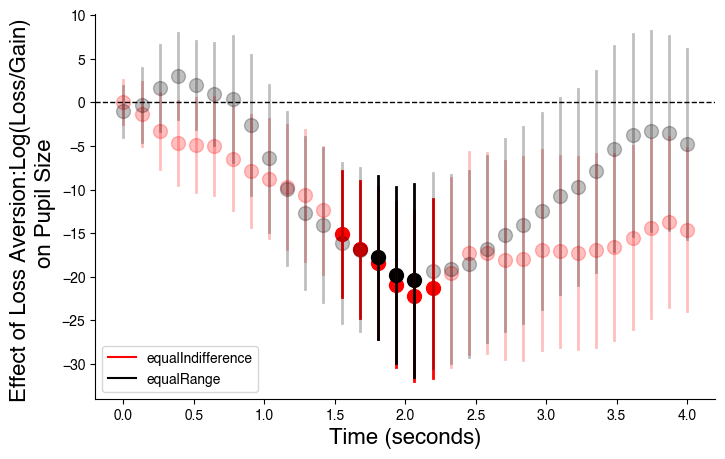

In [48]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'param_value:poly(loss_over_gain, 2)1'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", label="equalIndifference")
ax.plot([], [], color = "black", label="equalRange")
ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of Loss Aversion:Log(Loss/Gain) \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
# if linear_term.shape[0] > 0:
#     ax.axvspan(min(linear_term), max(linear_term), color="red", alpha=0.1)
plt.show()

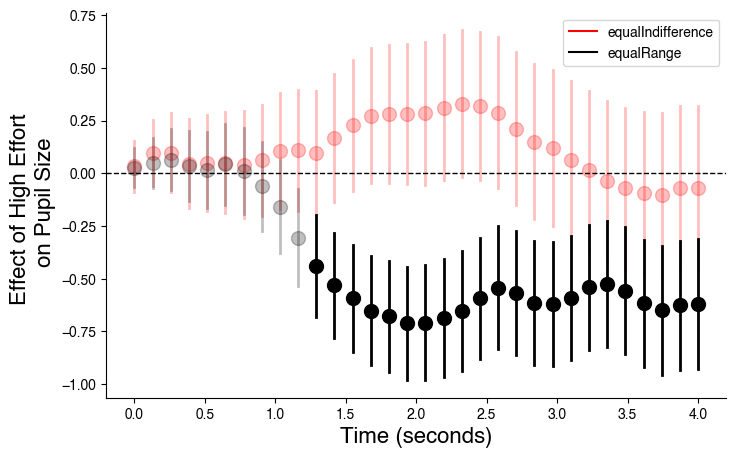

In [42]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'effortHigh'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", label="equalIndifference")
ax.plot([], [], color = "black", label="equalRange")
ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of High Effort \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
# if linear_term.shape[0] > 0:
#     ax.axvspan(min(linear_term), max(linear_term), color="red", alpha=0.1)
plt.show()

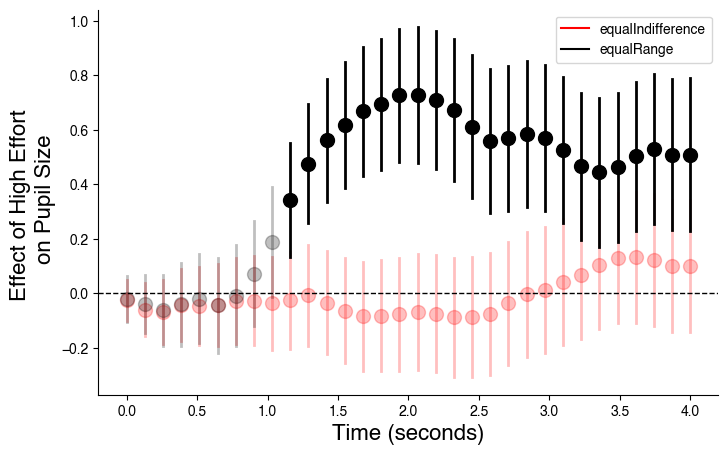

In [24]:
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 5))
grouped_df = results_individual.query("term == 'effortHigh:param_value'").sort_values(["timebin", "condition"]).reset_index(drop=True)

# For each timebin, plot the estimate of the gain effect for each condition. If the pvalue is not significant, alpha = 0.25
for i, row in grouped_df.iterrows():
    if row["p_value"] < 0.05:
        alpha = 1
    else:
        alpha = 0.25
    if row["condition"] == "equalIndifference":
        color = "red"
    elif row["condition"] == "equalRange":
        color = "black"
    ax.plot([row["timebin"], row["timebin"]], [row["conf.low"], row["conf.high"]], color=color, linewidth=2, alpha=alpha)
    ax.scatter(row["timebin"], row["estimate"], color=color, s=100, alpha=alpha)

ax.plot([], [], color = "red", label="equalIndifference")
ax.plot([], [], color = "black", label="equalRange")
ax.set_xlabel("Time (seconds)", fontsize=16)
ax.set_ylabel("Effect of High Effort \n on Pupil Size", fontsize=16)
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)
# Add horizontal line at y=0
ax.axhline(0, color="black", linestyle="--", linewidth=1)
# Add legend where red is equalIndifference and black is equalRange
plt.legend()
# if linear_term.shape[0] > 0:
#     ax.axvspan(min(linear_term), max(linear_term), color="red", alpha=0.1)
plt.show()

In [ ]:
%%R -o results
# loop through timebins
results <- data.frame()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    model = lmer(pupil_size ~ effort*condition*param_value + poly(loss_gain, 2)*condition + RT*condition + blink*condition + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub), data=data[data$timebin == tb, ])
    # Gather results
    model_result <- tidy(model, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
    model_result$timebin <- tb
    # Append results
    results <- rbind(results, model_result)
}

In [15]:
%%R -o residual_pupil
# loop through timebins
residual_pupil <- data.frame()
# Create a copy of data with sub, loss_over_gain, gain, loss, condition

for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    model = lmer(pupil_size ~ RT*condition + blink*condition + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub), data=data[data$timebin == tb, ])

    # Gather results
    residuals <- residuals(model)
    results <- data.frame(pupil_residual = residuals, 
                        timebin = tb, 
                        sub = data[data$timebin == tb, "sub"], 
                        gain = data[data$timebin == tb, "gain"], 
                        loss = data[data$timebin == tb, "loss"], 
                        condition = data[data$timebin == tb, "condition"], 
                        RT = data[data$timebin == tb, "RT"],
                        accept = data[data$timebin == tb, "accept"], 
                        loss_over_gain = data[data$timebin == tb, "loss_over_gain"])
    residual_pupil <- rbind(residual_pupil, results)
}

boundary (singular) fit: see help('isSingular')
In addition: Warning messages:
1: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00274893 (tol = 0.002, component 1)
2: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00242003 (tol = 0.002, component 1)
3: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00278892 (tol = 0.002, component 1)


In [17]:
# Create 3 quantiles of loss_over_gain
residual_pupil["loss_gain_quantile"] = pd.qcut(residual_pupil["loss_over_gain"], 3, labels=["Good", "Okay", "Bad"])

In [1]:
residual_pupil

NameError: name 'residual_pupil' is not defined

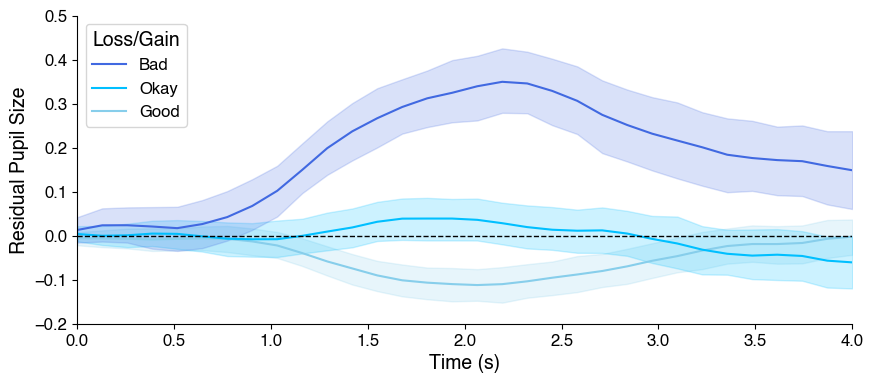

In [21]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Good': 'skyblue', 'Okay': 'deepskyblue', 'Bad': 'royalblue'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=residual_pupil.query("condition == 'equalIndifference'"), x="timebin", y="pupil_residual", hue="loss_gain_quantile", palette=color_palette, ax=ax)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 4)
ax.set_ylim(-0.2, 0.50)
# Set order of legend
handles, labels = ax.get_legend_handles_labels()
order = ['Bad', 'Okay', 'Good']
handles = [handles[labels.index(o)] for o in order]
plt.legend(handles=handles, title="Loss/Gain", fontsize=12, title_fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

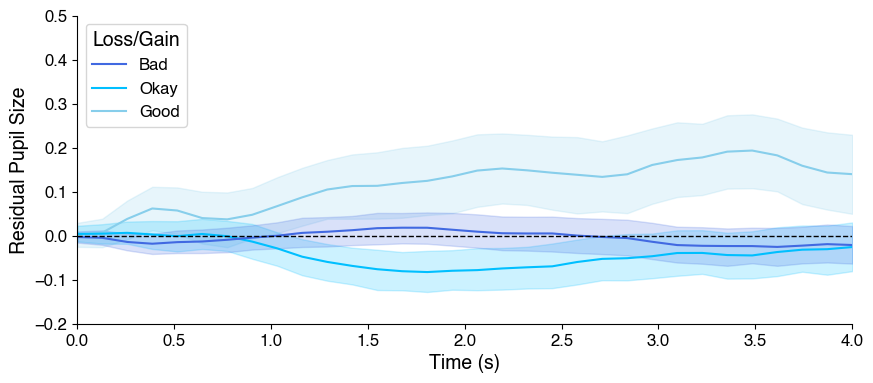

In [22]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Good': 'skyblue', 'Okay': 'deepskyblue', 'Bad': 'royalblue'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=residual_pupil.query("condition == 'equalRange'"), x="timebin", y="pupil_residual", hue="loss_gain_quantile", palette=color_palette, ax=ax)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 4)
ax.set_ylim(-0.2, 0.50)
# Set order of legend
handles, labels = ax.get_legend_handles_labels()
order = ['Bad', 'Okay', 'Good']
handles = [handles[labels.index(o)] for o in order]
plt.legend(handles=handles, title="Loss/Gain", fontsize=12, title_fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()